In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.tokenize import word_tokenize
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity



In [4]:
#Real Data

real_data = pd.read_csv('Arabic_dialects_Larger.csv')
texts_real = real_data['sent']
labels_all = real_data['label']

In [5]:
print(real_data.head())
print(real_data.info())

   sentID.BTEC                          split lang  \
0         2100   corpus-6-test-corpus-26-test  BAS   
1        10182  corpus-6-test-corpus-26-train  JED   
2        16292   corpus-6-test-corpus-26-test  ALG   
3          412                 corpus-6-train  DOH   
4         9431  corpus-6-test-corpus-26-train  MUS   

                              sent     label  
0                 باك محفظتي وشرد.     Iraqi  
1    منظر حلو. دي ممرات مشاة حلوة.      Gulf  
2  تقدر تديني لكانترباري و ترجعني؟  Maghrebi  
3           هذي هدية. ممكن تغلفها؟      Gulf  
4              اهني واحده لك سيدي.      Gulf  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10007 entries, 0 to 10006
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentID.BTEC  10007 non-null  int64 
 1   split        10007 non-null  object
 2   lang         10007 non-null  object
 3   sent         10007 non-null  object
 4   label        10007 non-null  objec


Label Distribution Analysis:


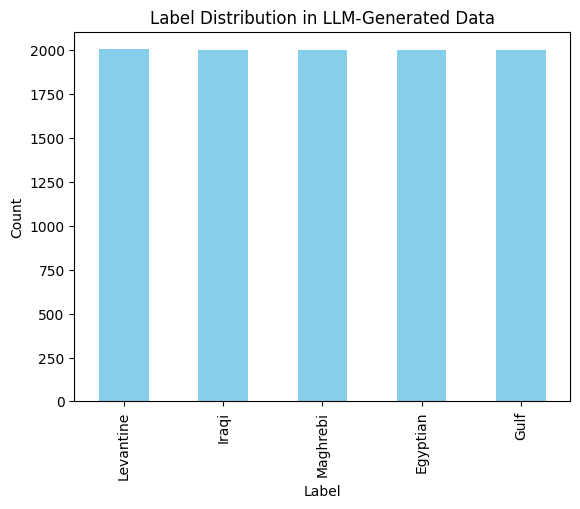

Label Distribution (%):
label
Levantine    20.025982
Iraqi        19.996003
Maghrebi     19.996003
Egyptian     19.996003
Gulf         19.986010
Name: count, dtype: float64


In [6]:
print("\nLabel Distribution Analysis:")
label_counts = labels_all.value_counts()
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution in LLM-Generated Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
print("Label Distribution (%):")
print((label_counts / len(labels_all)) * 100)

In [7]:
# Check for data types and unique values per feature
data=real_data
print(data.dtypes)

# Describe statistics for a quick overview
print(data.describe())


sentID.BTEC     int64
split          object
lang           object
sent           object
label          object
dtype: object
        sentID.BTEC
count  10007.000000
mean   10119.660737
std     5893.081569
min       11.000000
25%     4790.000000
50%    10125.000000
75%    15331.000000
max    19968.000000


In [14]:
# Check for duplicate rows
duplicate_rows = data[data.duplicated()]

print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

# Removing duplicate rows
data = data.drop_duplicates()


Number of duplicate rows: 0


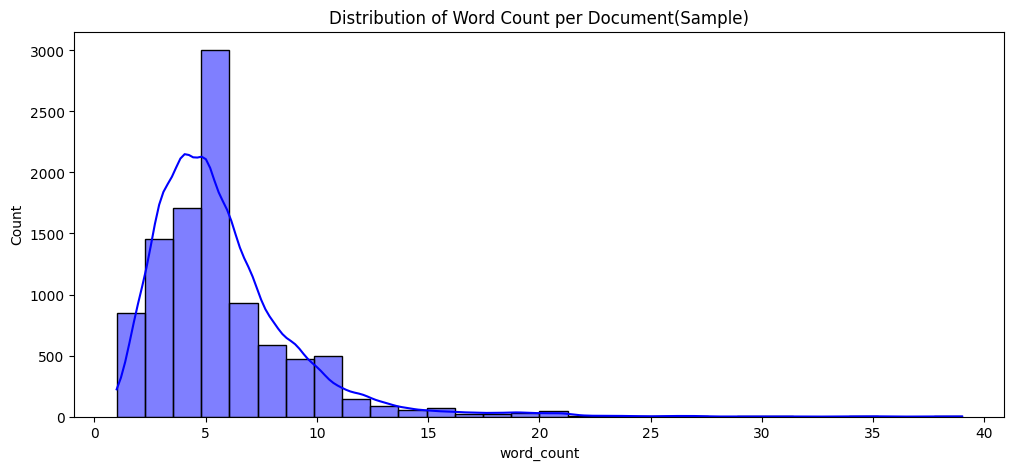

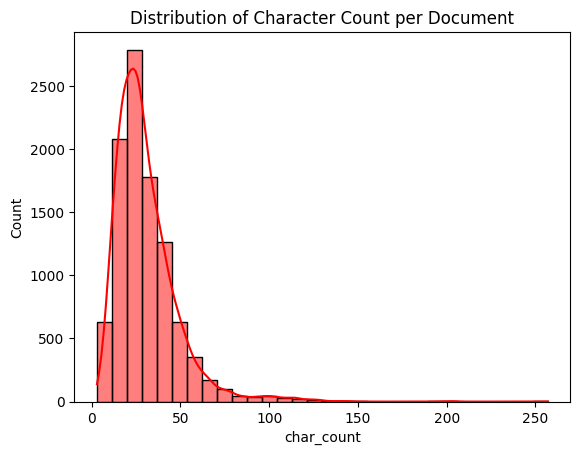

In [16]:
# Example: Checking average word length and character count per document
data['word_count'] = data['sent'].apply(lambda x: len(str(x).split()))
data['char_count'] = data['sent'].apply(lambda x: len(str(x)))

# Plotting distribution of word count and character count
plt.figure(figsize=(12, 5))
sns.histplot(data['word_count'], bins=30, kde=True, color='blue')
plt.title('Distribution of Word Count per Document(Sample)')
plt.show()

sns.histplot(data['char_count'], bins=30, kde=True, color='red')
plt.title('Distribution of Character Count per Document')
plt.show()


#This distribution suggests a dataset with short text entries that have somewhat consistent length

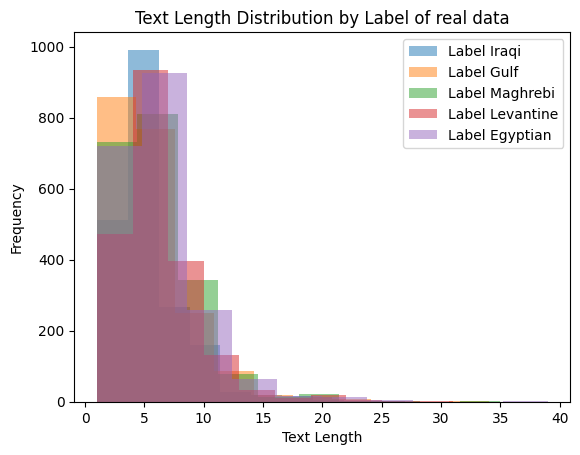

In [8]:
import matplotlib.pyplot as plt

# Calculate text lengths
data['text_length'] = data['sent'].apply(lambda x: len(x.split()))

# Plot histograms for each label's text length distribution
for label in data['label'].unique():
    subset = data[data['label'] == label]
    plt.hist(subset['text_length'], bins=10, alpha=0.5, label=f"Label {label}")

plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.legend()
plt.title("Text Length Distribution by Label of real data")
plt.show()
#The figure shows that text length distributions for all labels are very similar, with significant overlap. 
# This indicates that text length alone is unlikely to be a distinguishing feature for these labels.

In [20]:
# Tokenizing texts to count unique words
words = data['sent'].str.split()
all_words = list(itertools.chain(*words))
unique_words = Counter(all_words)

print(f"Total number of words: {len(all_words)}")
print(f"Number of unique words: {len(unique_words)}")
print(f"Most common words: {unique_words.most_common(10)}")


Total number of words: 57498
Number of unique words: 14587
Most common words: [('من', 1042), ('على', 680), ('.', 623), ('في', 623), ('ممكن', 611), ('لو', 604), ('ما', 378), ('و', 341), ('سمحت.', 302), ('أنا', 285)]


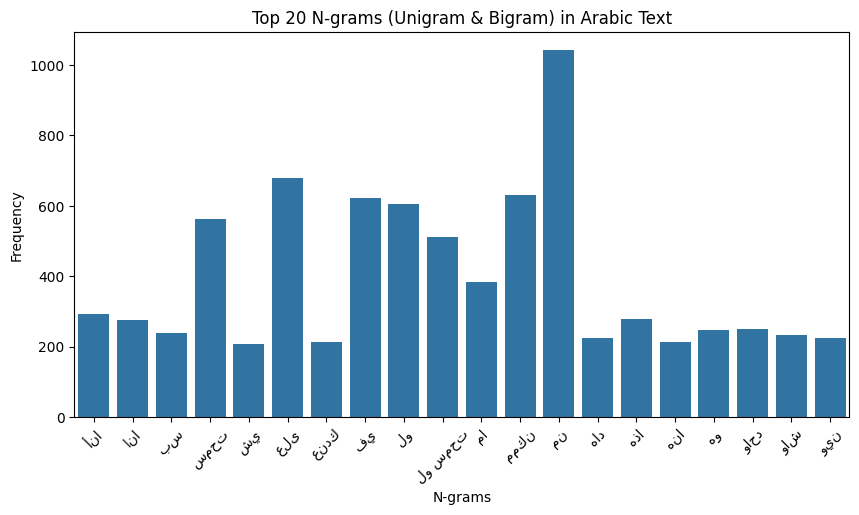

In [22]:
# Unigram and Bigram Analysis
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=20, analyzer='word')
X = vectorizer.fit_transform(data['sent'])
ngram_counts = np.asarray(X.sum(axis=0)).flatten()
ngram_labels = vectorizer.get_feature_names_out()

# Plotting the most frequent n-grams
plt.figure(figsize=(10, 5))
sns.barplot(x=ngram_labels, y=ngram_counts)
plt.xticks(rotation=45)
plt.title('Top 20 N-grams (Unigram & Bigram) in Arabic Text')
plt.xlabel('N-grams')
plt.ylabel('Frequency')
plt.show()
#This helps to see if the LLM-generated data includes natural and common phrases in Arabic, which would indicate high-quality generation


,Egyptian,Gulf,Iraqi,Levantine,Maghrebi
براشيم,1.0,0.0,0.0,0.0,0.0
الهضم,2.0,0.0,3.0,0.0,2.0
وبراشيم,1.0,0.0,0.0,0.0,0.0
المعدة,2.0,0.0,2.0,0.0,4.0
مختلفين،,2.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
شابين,0.0,0.0,0.0,0.0,1.0
سلالة,0.0,0.0,0.0,0.0,1.0
تعهم؟,0.0,0.0,0.0,0.0,1.0
وخا,0.0,0.0,0.0,0.0,1.0


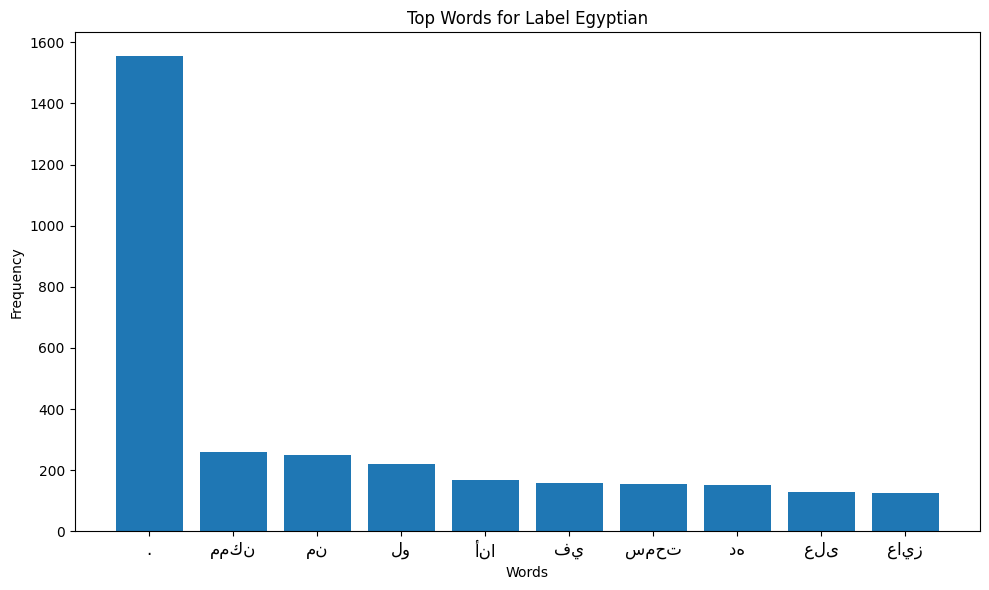

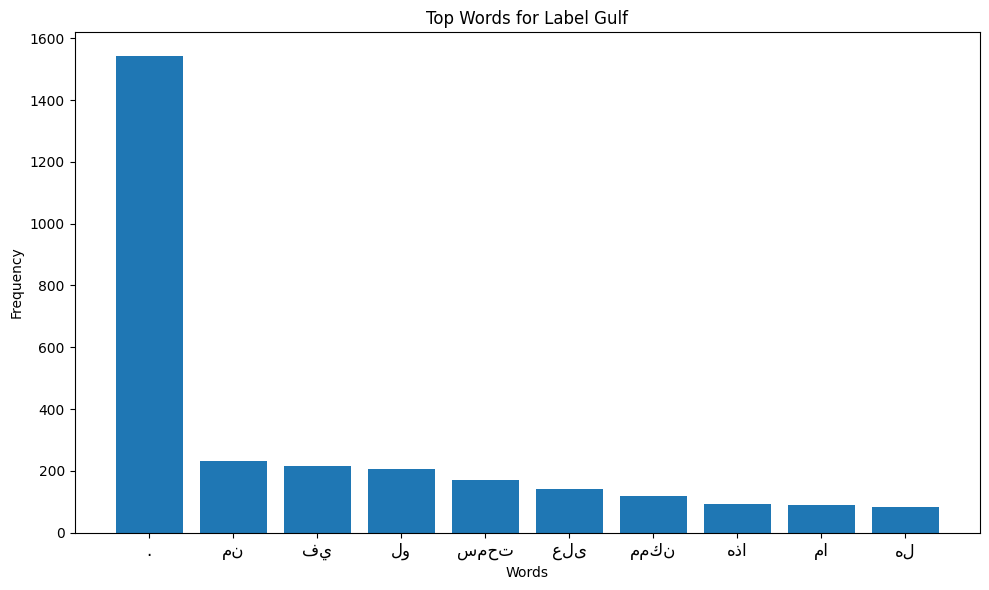

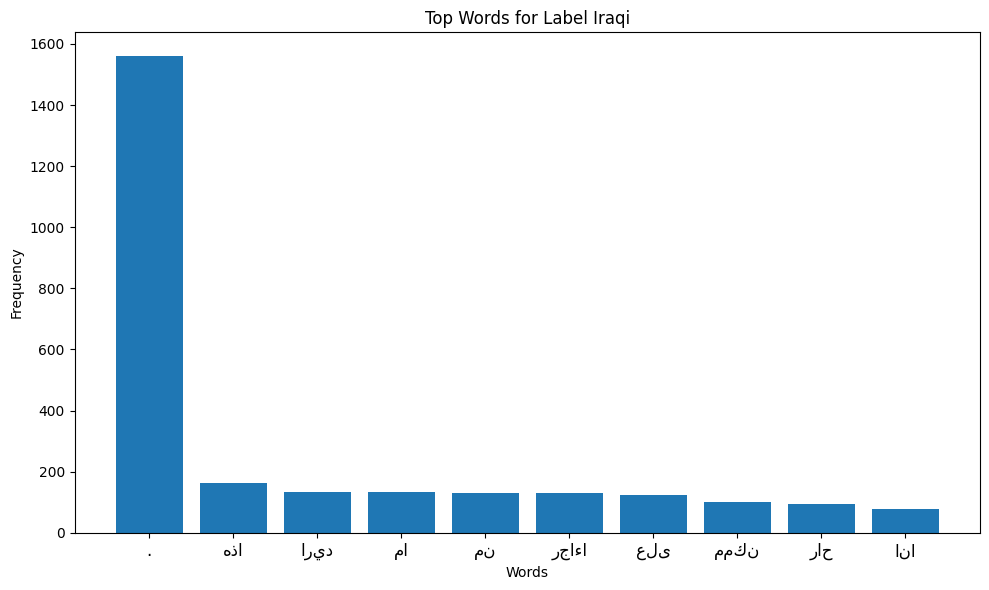

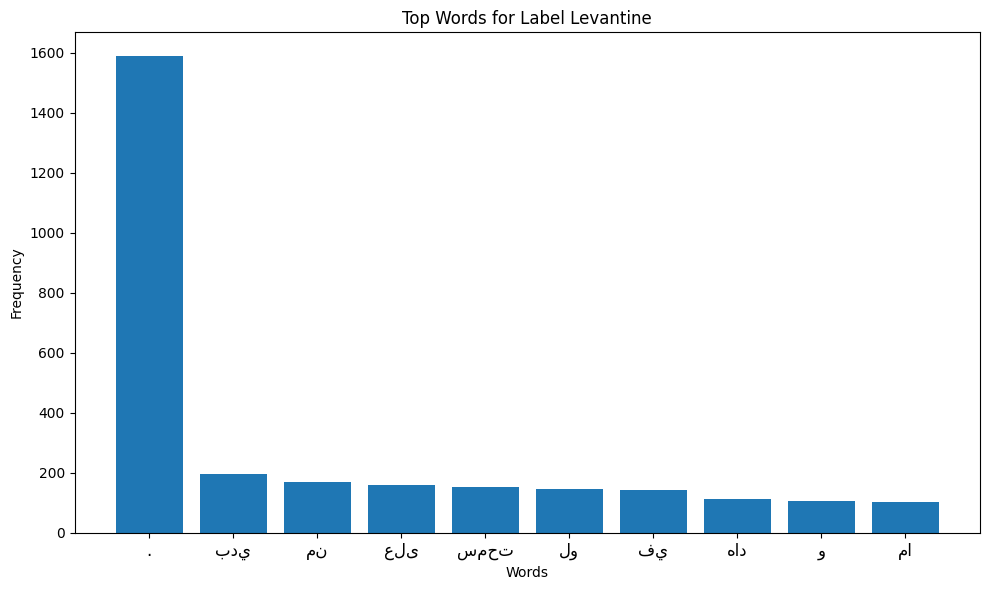

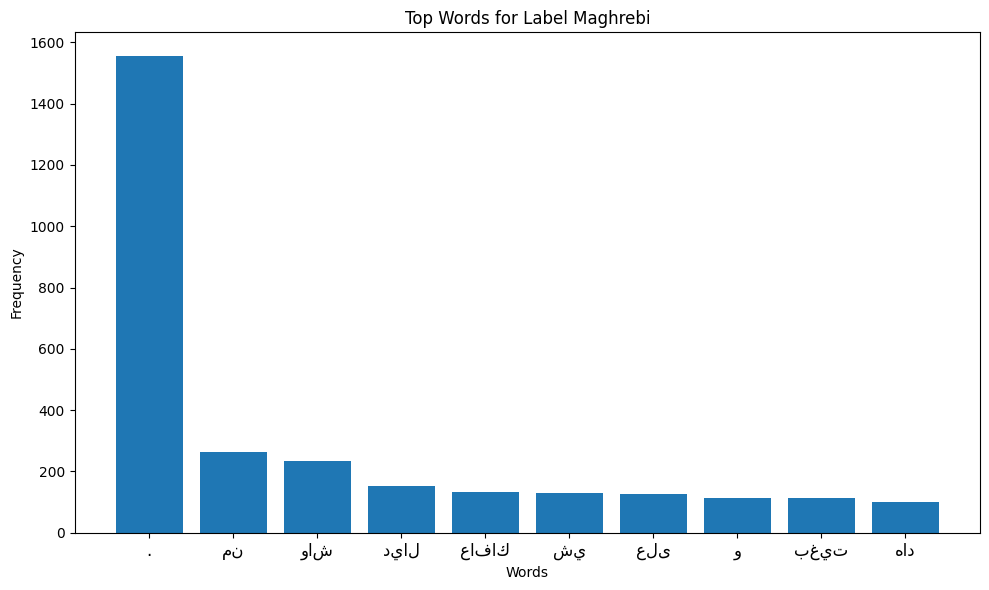

,آبى,آبي,آتمنى,آثار,آجر,آجى,آجي,آخد,آخدلك,آخدله,...,يوليو,يوليوز,يوم,يوماين,يومية,يومين,يونايتد,يونيو,يونيون,ييحصلون
Egyptian,0.002209,0.001244,0.000000,0.000000,0.004417,0.002209,0.000000,0.048114,0.000000,0.002209,...,0.003564,0.000000,0.031574,0.000000,0.000000,0.004210,0.002489,0.001782,0.001782,0.000000
Gulf,0.000000,0.000000,0.003039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002452,0.000000,0.033307,0.000000,0.000000,0.007241,0.003424,0.000000,0.002452,0.003039
Iraqi,0.000000,0.001533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.032419,0.000000,0.005443,0.001297,0.000000,0.000000,0.000000,0.000000
Levantine,0.000000,0.004591,0.000000,0.000000,0.000000,0.000000,0.004383,0.028492,0.002717,0.000000,...,0.000000,0.000000,0.025889,0.000000,0.000000,0.007767,0.003061,0.000000,0.000000,0.000000
Maghrebi,0.000000,0.001154,0.000000,0.002048,0.000000,0.000000,0.001652,0.000000,0.000000,0.000000,...,0.000000,0.004095,0.008782,0.008191,0.000000,0.000976,0.002307,0.001652,0.000000,0.000000


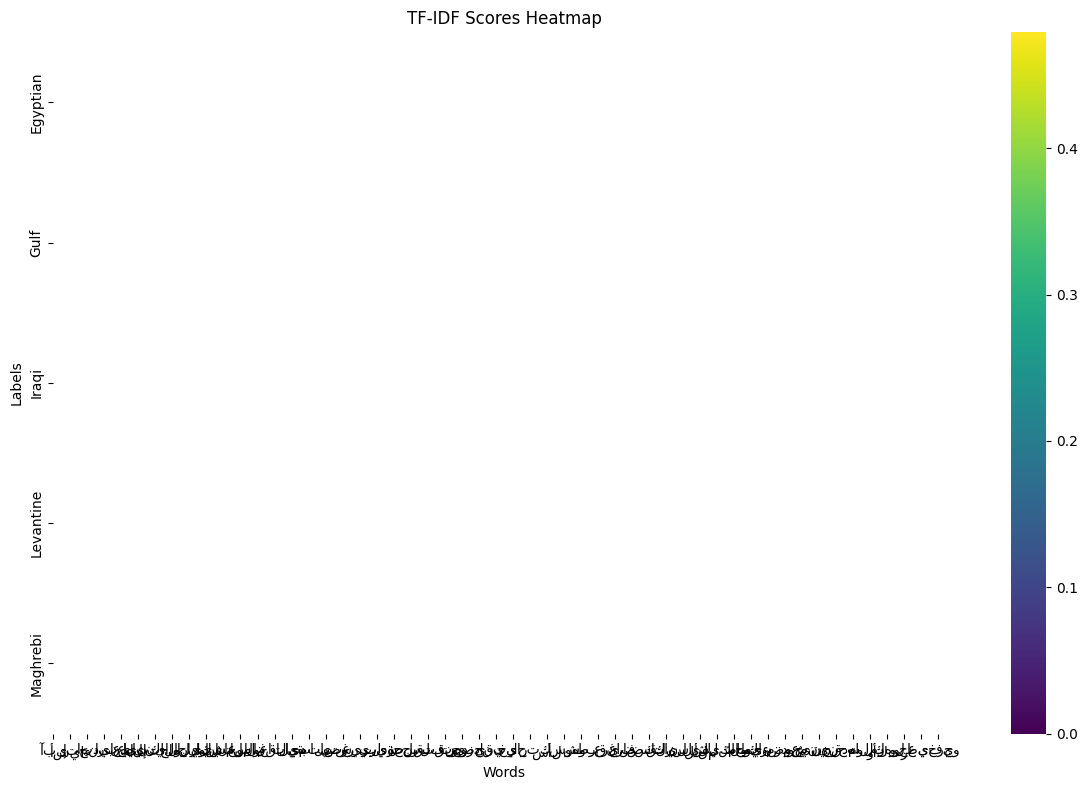

In [24]:
# Group texts by their label for word frequency analysis
data_by_label = data.groupby('label')['sent'].apply(lambda x: " ".join(x)).to_dict()

# Word frequency by label (improved word splitting for Arabic)
word_counts = {label: Counter(word_tokenize(text)) for label, text in data_by_label.items()}
word_count_df = pd.DataFrame(word_counts).fillna(0)
display(word_count_df)

# Visualization of word frequency (bar plots for each label)
for label in word_count_df.columns:
    plt.figure(figsize=(10, 6))
    top_words = word_count_df[label].nlargest(10)
    plt.bar(top_words.index, top_words.values)
    plt.title(f'Top Words for Label {label}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0, ha='center', fontsize=12)  # Adjusted rotation to 0 and centered for better readability
    plt.tight_layout()
    plt.show()

# TF-IDF analysis for vocabulary uniqueness (with improved tokenizer)
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\b[\w؀-ۿ]{2,}\b')  # Exclude single characters to avoid letters, include Arabic characters
texts_by_label = list(data_by_label.values())

# Fit and transform the TF-IDF model
tfidf_matrix = vectorizer.fit_transform(texts_by_label)

# Create a DataFrame for TF-IDF values
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=data_by_label.keys(), columns=vectorizer.get_feature_names_out())
display(tfidf_df)

# Visualization of TF-IDF results (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_df, cmap='viridis', linewidths=0.5)
plt.title('TF-IDF Scores Heatmap')
plt.xlabel('Words')
plt.ylabel('Labels')
plt.xticks(rotation=0, ha='center', fontsize=10)  # Adjusted font size and rotation for better readability
plt.tight_layout()
plt.show()


In [26]:
# Load embedding model
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get embeddings
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Compute embeddings and group by label
embeddings = {label: [get_embedding(text) for text in data[data['label'] == label]['sent']] for label in data['label'].unique()}

# Calculate average similarity within each label
for label, emb_list in embeddings.items():
    similarities = cosine_similarity(emb_list)
    avg_similarity = np.mean(similarities)
    print(f"Average cosine similarity within {label}: {avg_similarity:.4f}")


Average cosine similarity within Iraqi: 0.5955
Average cosine similarity within Gulf: 0.5771
Average cosine similarity within Maghrebi: 0.6057
Average cosine similarity within Levantine: 0.5948
Average cosine similarity within Egyptian: 0.6030


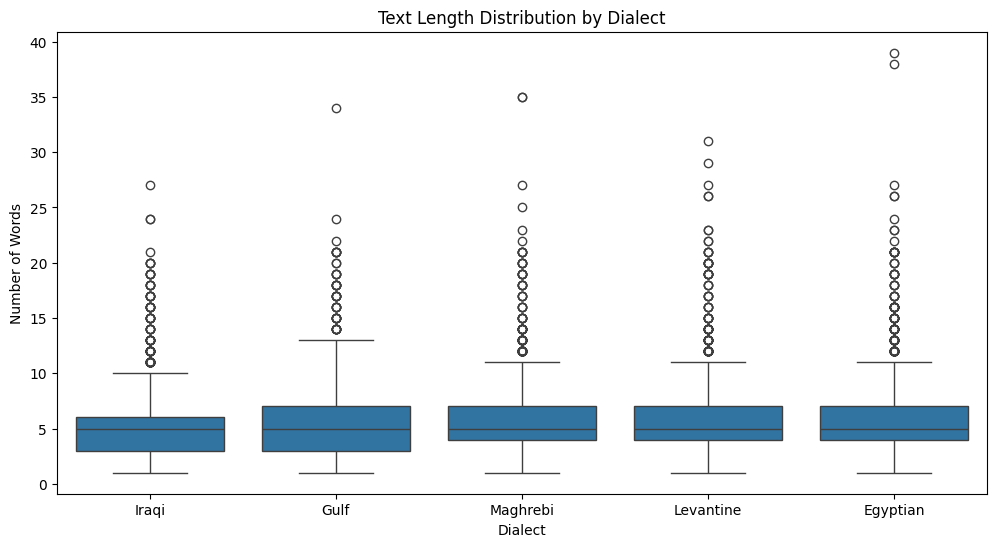

In [28]:
# Assuming 'data' is your DataFrame with 'text' and 'label' columns
data['text_length'] = data['sent'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='text_length', data=data)
plt.title('Text Length Distribution by Dialect')
plt.xlabel('Dialect')
plt.ylabel('Number of Words')
plt.show()

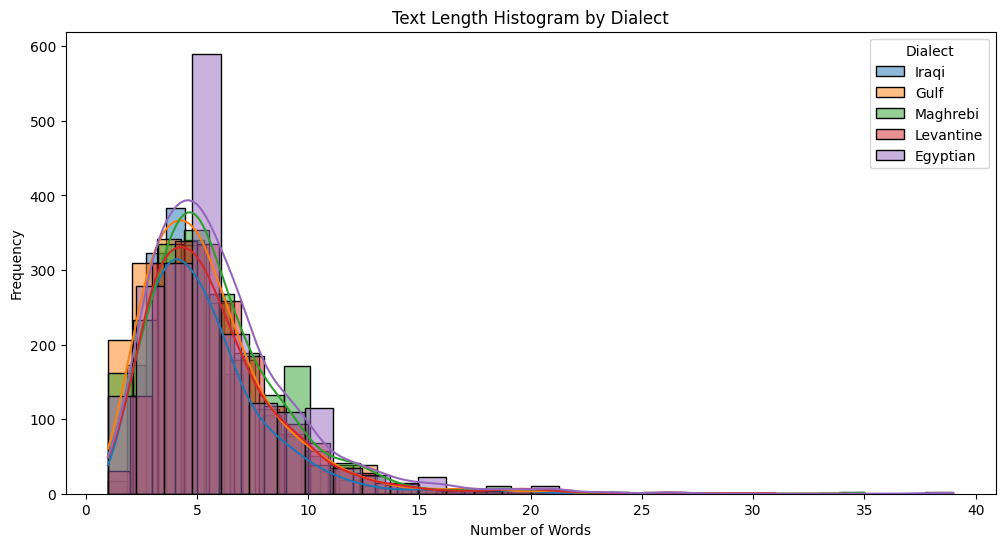

In [29]:
plt.figure(figsize=(12, 6))
for label in data['label'].unique():
    subset = data[data['label'] == label]
    sns.histplot(subset['text_length'], kde=True, label=label, bins=30, alpha=0.5)
plt.title('Text Length Histogram by Dialect')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend(title='Dialect')
plt.show()

In [31]:
from collections import Counter

def unique_word_count(texts):
    all_words = ' '.join(texts).split()
    return len(set(all_words))

unique_words = data.groupby('label')['sent'].apply(unique_word_count)
print(unique_words)


label
Egyptian     4555
Gulf         4386
Iraqi        4215
Levantine    3878
Maghrebi     5018
Name: sent, dtype: int64


In [10]:
# Assuming `llm_data` is your DataFrame and it has a column named 'Text'

# Function to count unique words across the entire dataset
def calculate_unique_words(data):
    all_words = ' '.join(data['sent']).split()  # Combine all sentences and split into words
    unique_words = set(all_words)  # Get unique words
    return len(unique_words)

# Calculate unique words in the LLM-generated dataset
total_unique_words = calculate_unique_words(real_data)
print(f"Total unique words in LLM-generated data: {total_unique_words}")


Total unique words in LLM-generated data: 14587


In [ ]:
from scipy.stats import f_oneway

groups = [group['text_length'].values for name, group in data.groupby('label')]
f_stat, p_val = f_oneway(*groups)
print(f'ANOVA F-statistic: {f_stat}, p-value: {p_val}')


ANOVA F-statistic: 16.417850816744703, p-value: 2.0552509957287237e-13
